In [7]:
pip install numpy tensorflow matplotlib opencv-python


Note: you may need to restart the kernel to use updated packages.


In [10]:
!pip install scikit-learn


  Using cached scikit_learn-1.6.1-cp311-cp311-win_amd64.whl.metadata (15 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.6.1-cp311-cp311-win_amd64.whl (11.1 MB)
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
   ---------------------------------------- 0.0/41.2 MB ? eta -:--:--
   - -------------------------------------- 1.6/41.2 MB 10.5 MB/s eta 0:00:04
   --- ------------------------------------ 3.4/41.2 MB 8.8 MB/s eta 0:00:05
   ---- ----------------------------------- 5.0/41.2 MB 8.4 MB/s eta 0:00:05
   ----- ---------------------------------- 6.0/41.2 MB 8.0 MB/s eta 0:00:05
   ------ --------------------------------- 6.8/41.2 MB 6.8 MB/s eta 0:00:06
   ------- -------------------------------- 7.6/41.2 MB 6.4 MB/s eta 0:00:06
   -------- ------------------------------- 8.7/41.2 MB 6.2 MB/s eta 0:00:06
   --------- ------------------------------ 10.0/41.2 MB 6.1 

In [2]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118
  Using cached https://download.pytorch.org/whl/cu118/torch-2.6.0%2Bcu118-cp311-cp311-win_amd64.whl.metadata (28 kB)
  Using cached https://download.pytorch.org/whl/cu118/torchvision-0.21.0%2Bcu118-cp311-cp311-win_amd64.whl.metadata (6.3 kB)
  Using cached https://download.pytorch.org/whl/cu118/torchaudio-2.6.0%2Bcu118-cp311-cp311-win_amd64.whl.metadata (6.8 kB)
     ---------------------------------------- 0.0/6.2 MB ? eta -:--:--
     ----------- ---------------------------- 1.8/6.2 MB 9.1 MB/s eta 0:00:01
     ------------------------- -------------- 3.9/6.2 MB 10.2 MB/s eta 0:00:01
     -------------------------------------- - 6.0/6.2 MB 10.5 MB/s eta 0:00:01
     ---------------------------------------- 6.2/6.2 MB 9.7 MB/s eta 0:00:00
     ---------------------------------------- 0.0/536.2 kB ? eta -:--:--
     -------------------------------------- 536.2/536.2 kB 5.8 MB/s eta 0:00:00
Using cached https://download.pytorch.

In [6]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install tensorflow opencv-python matplotlib


Looking in indexes: https://download.pytorch.org/whl/cu118


In [8]:
!pip install torch torchvision torchaudio
!pip install tensorflow opencv-python matplotlib


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import cv2
import matplotlib.pyplot as plt


In [10]:


# Check if GPU is available and set device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [11]:
# Transformations for normalizing the images and converting to tensor
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Download CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


100.0%


In [14]:
class GrayToColorDataset(Dataset):
    def __init__(self, original_dataset):
        self.original_dataset = original_dataset

    def __len__(self):
        return len(self.original_dataset)

    def __getitem__(self, idx):
        # Get the original image (color)
        color_image, label = self.original_dataset[idx]

        # Convert to grayscale
        gray_image = color_image.mean(dim=0, keepdim=True)  # average across the color channels to create a grayscale image
        gray_image = gray_image.repeat(3, 1, 1)  # Repeat grayscale to make it 3 channels

        return gray_image, color_image


In [15]:
class GrayToColorCNN(nn.Module):
    def __init__(self):
        super(GrayToColorCNN, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()  # Output should be in the range [0, 1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [16]:
# Prepare DataLoader for train and test
train_dataset = GrayToColorDataset(train_dataset)
test_dataset = GrayToColorDataset(test_dataset)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Initialize the model, loss function, and optimizer
model = GrayToColorCNN().to(device)
criterion = nn.MSELoss()  # Mean squared error loss for image reconstruction
optimizer = optim.Adam(model.parameters(), lr=0.0001)


In [17]:
# Function to train the model
def train_model(model, train_loader, criterion, optimizer, num_epochs=20):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for gray_images, color_images in train_loader:
            gray_images, color_images = gray_images.to(device), color_images.to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(gray_images)

            # Compute the loss
            loss = criterion(outputs, color_images)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}")

# Start training the model
train_model(model, train_loader, criterion, optimizer, num_epochs=20)


Epoch [1/20], Loss: 0.009630927667164665
Epoch [2/20], Loss: 0.00574815148324527
Epoch [3/20], Loss: 0.005529325440838038
Epoch [4/20], Loss: 0.0054290814731922715
Epoch [5/20], Loss: 0.005335467037759112
Epoch [6/20], Loss: 0.005227946768910207
Epoch [7/20], Loss: 0.005170519364869122
Epoch [8/20], Loss: 0.0051188449514672505
Epoch [9/20], Loss: 0.005062138581650851
Epoch [10/20], Loss: 0.0050215909696396084
Epoch [11/20], Loss: 0.004985977437340028
Epoch [12/20], Loss: 0.004952961869854623
Epoch [13/20], Loss: 0.0049135568858388705
Epoch [14/20], Loss: 0.004902332016597967
Epoch [15/20], Loss: 0.004885031027383531
Epoch [16/20], Loss: 0.004860008248578176
Epoch [17/20], Loss: 0.004847307056795968
Epoch [18/20], Loss: 0.0048245334449340885
Epoch [19/20], Loss: 0.004821963776188814
Epoch [20/20], Loss: 0.004804109741845514


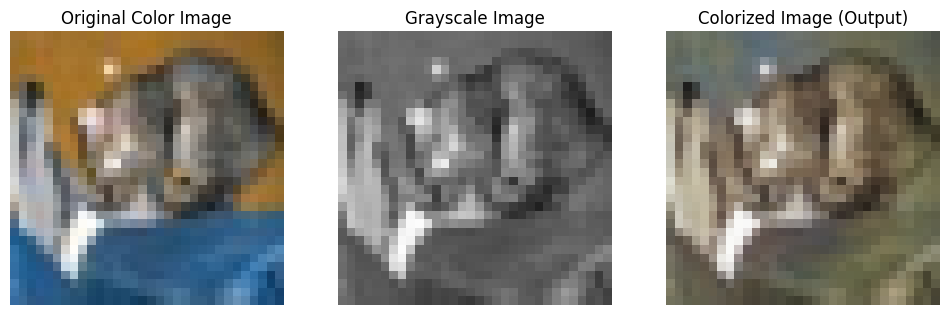

In [24]:
import matplotlib.pyplot as plt

def test_model(model, test_loader):
    model.eval()
    with torch.no_grad():
        for gray_images, color_images in test_loader:
            gray_images = gray_images.to(device)
            color_images = color_images.to(device)

            # Pass the grayscale images through the model
            output = model(gray_images)
            
            # Convert the tensor to numpy arrays for visualization
            output_image = output[0].cpu().numpy().transpose(1, 2, 0)
            gray_image = gray_images[0].cpu().numpy().transpose(1, 2, 0)  # Grayscale image
            original_image = color_images[0].cpu().numpy().transpose(1, 2, 0)  # Original color image
            
            # Plotting the images side by side
            plt.figure(figsize=(12, 4))
            
            # Original color image
            plt.subplot(1, 3, 1)
            plt.imshow(original_image)
            plt.title('Original Color Image')
            plt.axis('off')

            # Grayscale image
            plt.subplot(1, 3, 2)
            plt.imshow(gray_image, cmap='gray')
            plt.title('Grayscale Image')
            plt.axis('off')

            # Output colorized image
            plt.subplot(1, 3, 3)
            plt.imshow(output_image)
            plt.title('Colorized Image (Output)')
            plt.axis('off')
            
            plt.show()
            break  # Display only one image for testing

# Test the model after training
test_model(model, test_loader)
